In [1]:
import sys, os
sys.path.append(os.path.abspath('../src'))

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import train


In [2]:
# Importar módulos personalizados
from train import (
    build_dense_model, build_rnn_model, build_lstm_model,
    train_model, grid_search_dense
)
from evaluate import evaluate_model
from visualize import (
    plot_training_history, plot_confusion_matrix,
    plot_roc_curve, plot_precision_recall, compare_metrics
)

In [3]:
print("Cargando dataset preprocesado...")
df = pd.read_csv("../data/processed/clean_reviews.csv")
print(f"Dataset cargado: {df.shape}")
print(df.head())

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(
    df["clean_sentence"], df["label"],
    test_size=0.2, random_state=42
)

Cargando dataset preprocesado...
Dataset cargado: (2727, 2)
                                      clean_sentence  label
0        aimless movie distressed drifting young man      0
1  sure lost flat character audience nearly half ...      0
2  attempting artiness black white clever camera ...      0
3                        little music anything speak      0
4  best scene movie gerardo trying find song keep...      1


In [4]:
# --- Dense NN → TF-IDF ---
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()
input_dim = X_train_tfidf.shape[1]

# --- RNN / LSTM → Secuencias ---
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

maxlen = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen)
vocab_size = len(tokenizer.word_index) + 1


 Entrenando modelo Dense (Grid Search)...

 Entrenando Dense(64) | lr=0.001 | batch=32 | epochs=5

Epoch 1/5


69/69 [==============================] - 3s 12ms/step - loss: 0.6814 - accuracy: 0.6112 - val_loss: 0.6476 - val_accuracy: 0.7509
Epoch 2/5
69/69 [==============================] - 0s 7ms/step - loss: 0.4880 - accuracy: 0.8767 - val_loss: 0.4683 - val_accuracy: 0.7912
Epoch 3/5
69/69 [==============================] - 1s 9ms/step - loss: 0.2155 - accuracy: 0.9331 - val_loss: 0.4787 - val_accuracy: 0.7967
Epoch 4/5
69/69 [==============================] - 1s 8ms/step - loss: 0.1121 - accuracy: 0.9665 - val_loss: 0.5375 - val_accuracy: 0.7821
Epoch 5/5
69/69 [==============================] - 1s 7ms/step - loss: 0.0690 - accuracy: 0.9798 - val_loss: 0.6008 - val_accuracy: 0.7766
Val Accuracy: 0.7766

 Entrenando Dense(64) | lr=0.001 | batch=64 | epochs=5
Epoch 1/5
35/35 [==============================] - 2s 21ms/step - loss: 0.6903 - accuracy: 0.6149 - val_loss: 0.6824 - val_ac

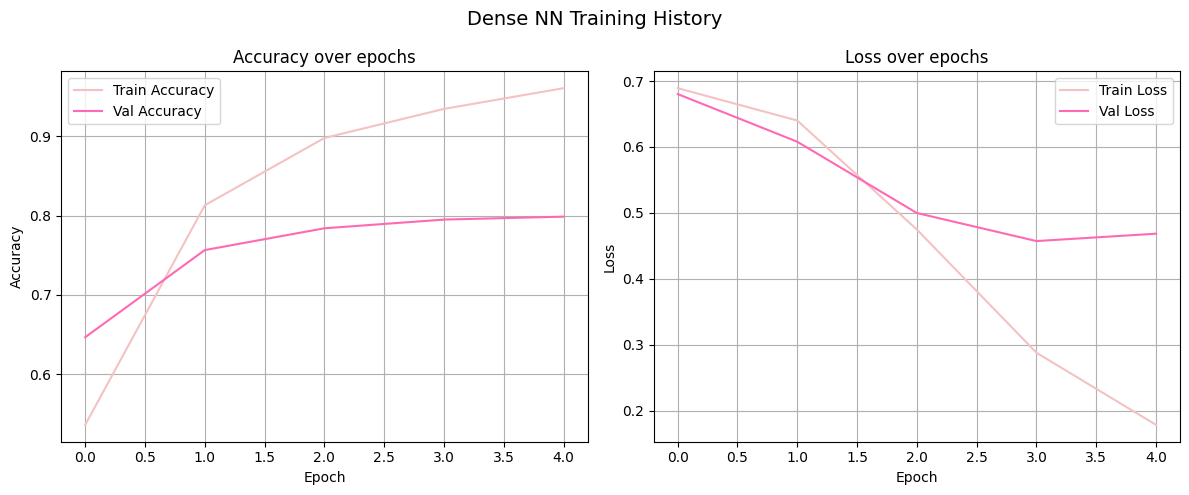

18/18 [==============================] - 0s 4ms/step
=== Evaluation Metrics ===
Accuracy : 0.7985
Precision: 0.7932
Recall   : 0.8269
F1-score : 0.8097
Cohen’s Kappa: 0.5959

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.77      0.79       263
           1       0.79      0.83      0.81       283

    accuracy                           0.80       546
   macro avg       0.80      0.80      0.80       546
weighted avg       0.80      0.80      0.80       546

18/18 [==============================] - 0s 3ms/step


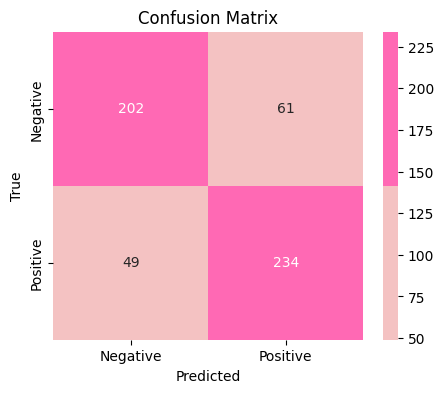

18/18 [==============================] - 0s 4ms/step


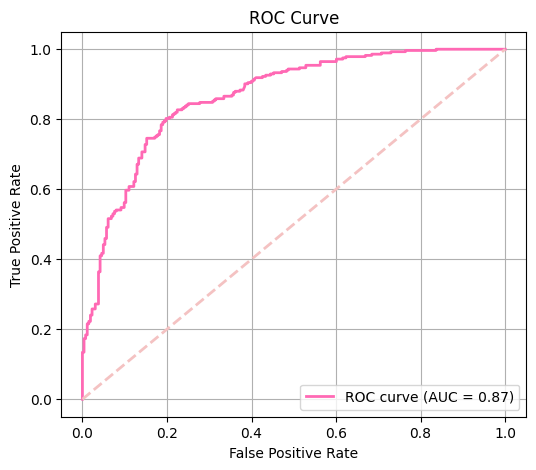

18/18 [==============================] - 0s 3ms/step


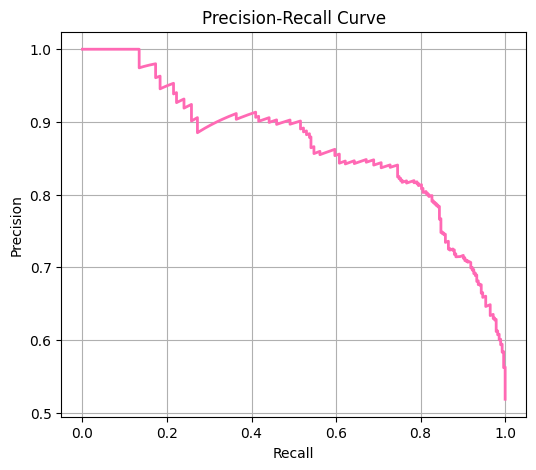

In [5]:
# Dense Neural Network con Grid Search
print("\n Entrenando modelo Dense (Grid Search)...")
best_dense, best_params, best_score = grid_search_dense(
    X_train_tfidf, y_train, X_test_tfidf, y_test, input_dim
)

print(f"Mejor configuración Dense: {best_params}")
plot_training_history(best_dense.history, "Dense NN Training History")

dense_results = evaluate_model(best_dense, X_test_tfidf, y_test)
y_pred_dense = (best_dense.predict(X_test_tfidf) > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred_dense)
plot_roc_curve(y_test, best_dense.predict(X_test_tfidf))
plot_precision_recall(y_test, best_dense.predict(X_test_tfidf))


 Entrenando modelo RNN...
Epoch 1/5
69/69 [==============================] - 5s 39ms/step - loss: 0.6944 - accuracy: 0.5213 - val_loss: 0.6605 - val_accuracy: 0.6319
Epoch 2/5
69/69 [==============================] - 2s 30ms/step - loss: 0.4559 - accuracy: 0.8900 - val_loss: 0.5338 - val_accuracy: 0.7271
Epoch 3/5
69/69 [==============================] - 2s 29ms/step - loss: 0.1591 - accuracy: 0.9523 - val_loss: 0.5706 - val_accuracy: 0.7253
Epoch 4/5
69/69 [==============================] - 2s 32ms/step - loss: 0.0785 - accuracy: 0.9771 - val_loss: 0.5653 - val_accuracy: 0.7454
Epoch 5/5
69/69 [==============================] - 2s 31ms/step - loss: 0.0746 - accuracy: 0.9743 - val_loss: 0.6312 - val_accuracy: 0.7454


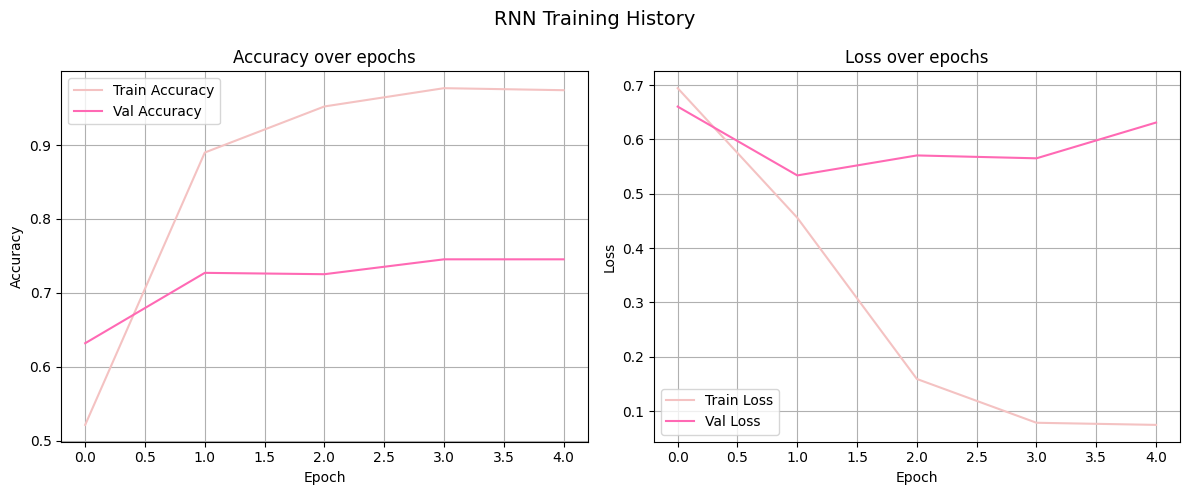

18/18 [==============================] - 0s 9ms/step
=== Evaluation Metrics ===
Accuracy : 0.7454
Precision: 0.7416
Recall   : 0.7809
F1-score : 0.7608
Cohen’s Kappa: 0.4891

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.71      0.73       263
           1       0.74      0.78      0.76       283

    accuracy                           0.75       546
   macro avg       0.75      0.74      0.74       546
weighted avg       0.75      0.75      0.74       546

18/18 [==============================] - 0s 9ms/step


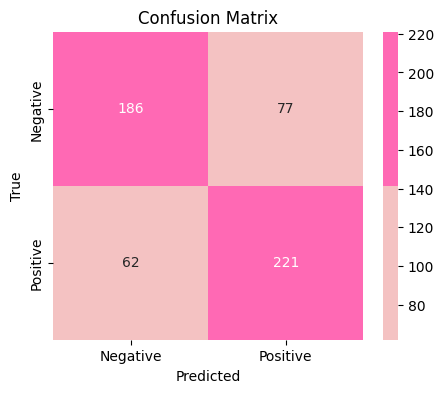

18/18 [==============================] - 0s 8ms/step


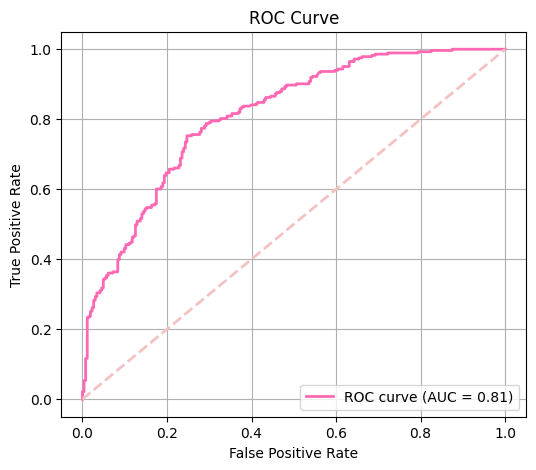

18/18 [==============================] - 0s 10ms/step


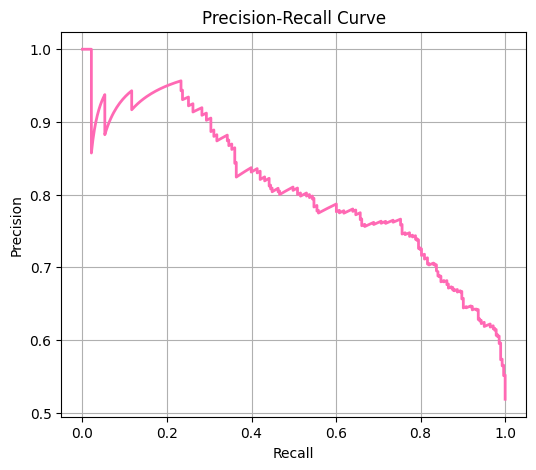

In [6]:
# Vanilla RNN
print("\n Entrenando modelo RNN...")
rnn_model = build_rnn_model(vocab_size)
rnn_model, history_rnn, _ = train_model(
    rnn_model, X_train_pad, y_train, X_test_pad, y_test,
    epochs=5, batch_size=32
)

plot_training_history(history_rnn, "RNN Training History")
rnn_results = evaluate_model(rnn_model, X_test_pad, y_test)
y_pred_rnn = (rnn_model.predict(X_test_pad) > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred_rnn)
plot_roc_curve(y_test, rnn_model.predict(X_test_pad))
plot_precision_recall(y_test, rnn_model.predict(X_test_pad))


 Entrenando modelo LSTM...
Epoch 1/5
69/69 [==============================] - 10s 80ms/step - loss: 0.6671 - accuracy: 0.6176 - val_loss: 0.5816 - val_accuracy: 0.7454
Epoch 2/5
69/69 [==============================] - 4s 61ms/step - loss: 0.3801 - accuracy: 0.8592 - val_loss: 0.4726 - val_accuracy: 0.7912
Epoch 3/5
69/69 [==============================] - 4s 64ms/step - loss: 0.2004 - accuracy: 0.9271 - val_loss: 0.5197 - val_accuracy: 0.7857
Epoch 4/5
69/69 [==============================] - 4s 60ms/step - loss: 0.1168 - accuracy: 0.9597 - val_loss: 0.5593 - val_accuracy: 0.7784
Epoch 5/5
69/69 [==============================] - 4s 61ms/step - loss: 0.0851 - accuracy: 0.9725 - val_loss: 0.6244 - val_accuracy: 0.7729


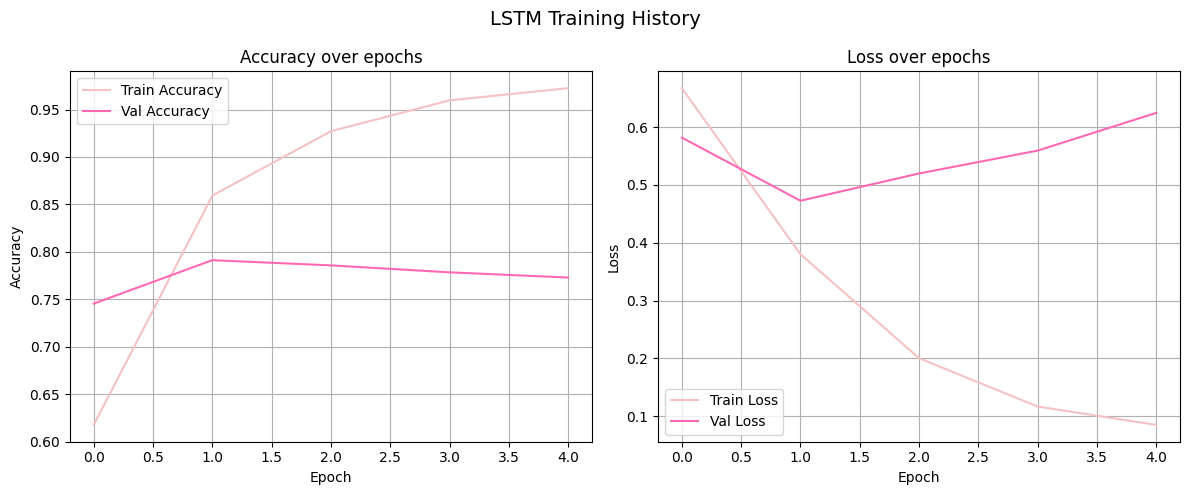

18/18 [==============================] - 1s 20ms/step
=== Evaluation Metrics ===
Accuracy : 0.7729
Precision: 0.7751
Recall   : 0.7915
F1-score : 0.7832
Cohen’s Kappa: 0.5448

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.75      0.76       263
           1       0.78      0.79      0.78       283

    accuracy                           0.77       546
   macro avg       0.77      0.77      0.77       546
weighted avg       0.77      0.77      0.77       546

18/18 [==============================] - 0s 21ms/step


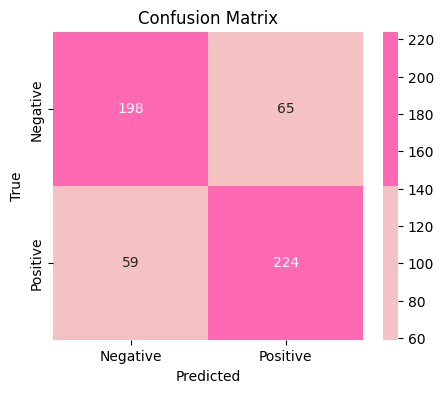

18/18 [==============================] - 0s 21ms/step


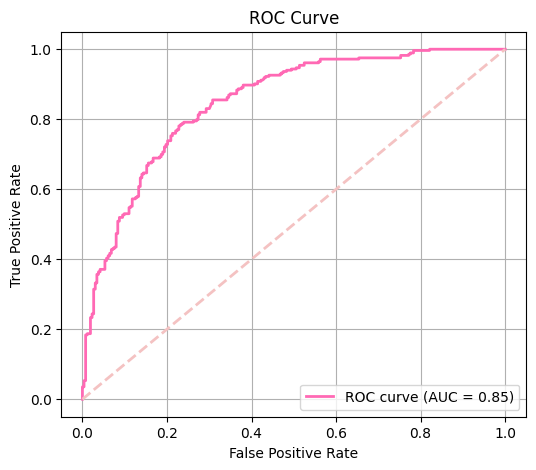

18/18 [==============================] - 0s 24ms/step


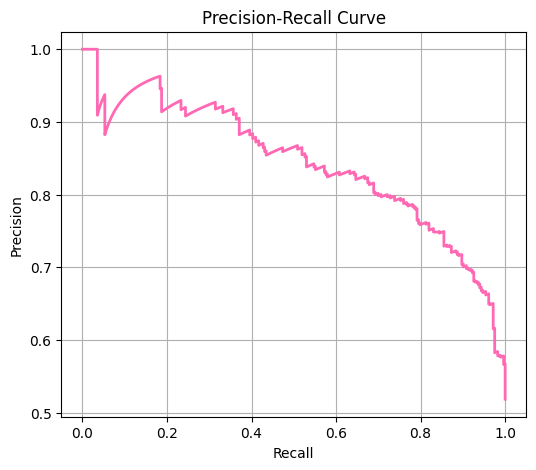

In [7]:
# LSTM
print("\n Entrenando modelo LSTM...")
lstm_model = build_lstm_model(vocab_size)
lstm_model, history_lstm, _ = train_model(
    lstm_model, X_train_pad, y_train, X_test_pad, y_test,
    epochs=5, batch_size=32
)

plot_training_history(history_lstm, "LSTM Training History")
lstm_results = evaluate_model(lstm_model, X_test_pad, y_test)
y_pred_lstm = (lstm_model.predict(X_test_pad) > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred_lstm)
plot_roc_curve(y_test, lstm_model.predict(X_test_pad))
plot_precision_recall(y_test, lstm_model.predict(X_test_pad))


 Comparando resultados...


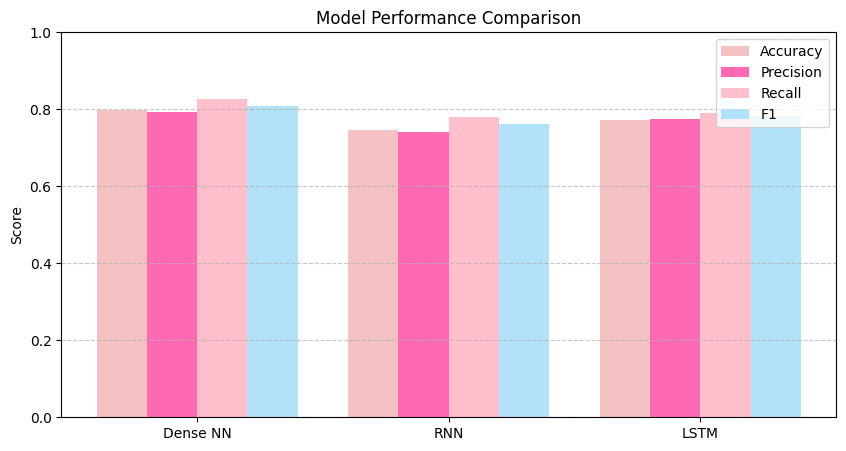

 Entrenamiento y evaluación completados.


In [8]:
# Comparación final de modelos
print("\n Comparando resultados...")
results_dict = {
    "Dense NN": dense_results,
    "RNN": rnn_results,
    "LSTM": lstm_results
}

compare_metrics(results_dict)
print(" Entrenamiento y evaluación completados.")
